In [3]:
# import utils as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy import optimize
from scipy.io import loadmat
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import pad_sequences
import os


In [4]:
def load_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

def import_key_data(path):
    gender=[]
    age=[]
    labels=[]
    ecg_filenames=[]
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".mat"):
                data, header_data = load_data(filepath)
                labels.append(header_data[15][5:-1])
                ecg_filenames.append(filepath)
                gender.append(header_data[14][6:-1])
                age.append(header_data[13][6:-1])
    return gender, age, labels, ecg_filenames

In [5]:
gender, age, labels, ecg_filenames = import_key_data("/home/petar/Desktop/sso/data/")
ecg_filenames = np.asarray(ecg_filenames)

In [6]:
# number of samples
len(ecg_filenames)

10344

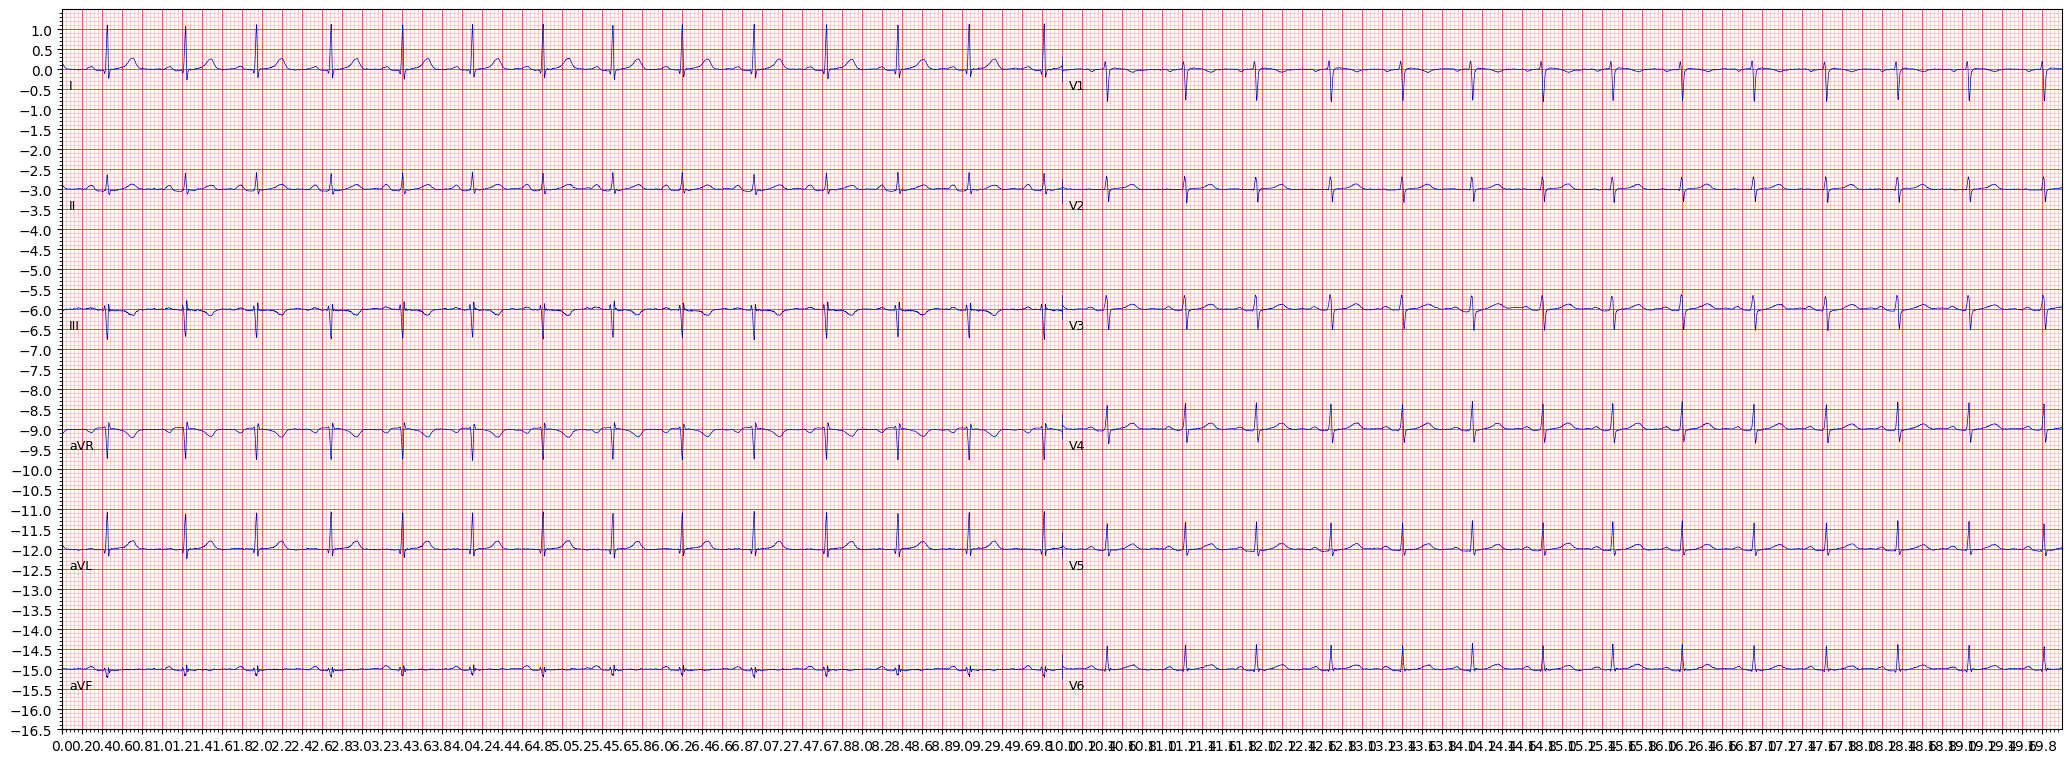

In [7]:
def plot_ecg(path):
    ecg_data = load_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()

plot_ecg('data/E00001.mat')

In [8]:
### UTILS

def make_undefined_class(labels, df_unscored):
    df_labels = pd.DataFrame(labels)
    for i in range(len(df_unscored.iloc[0:,1])):
        df_labels.replace(to_replace=str(df_unscored.iloc[i,1]), inplace=True ,value="undefined class", regex=True)
    return df_labels


def onehot_encode(df_labels):
    one_hot = MultiLabelBinarizer()
    y = one_hot.fit_transform(df_labels[0].str.split(pat=','))
    print("The classes we will look at are encoded as SNOMED CT codes:")
    print(one_hot.classes_)
    y = np.delete(y, -1, axis=1)
    print("classes: {}".format(y.shape[1]))
    return y, one_hot.classes_[0:-1]

def plot_classes(classes, scored_classes,y):
    for j in range(len(classes)):
        for i in range(len(scored_classes.iloc[:,1])):
            if (str(scored_classes.iloc[:,1][i]) == classes[j]):
                classes[j] = scored_classes.iloc[:,0][i]
    plt.figure(figsize=(30,20))
    plt.bar(x=classes,height=y.sum(axis=0))
    plt.title("Distribution of Diagnosis", color = "black", fontsize = 30)
    plt.tick_params(axis="both", colors = "black")
    plt.xlabel("Diagnosis", color = "black")
    plt.ylabel("Count", color = "black")
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize = 20)
    plt.savefig("fordeling.png")
    plt.show()


def get_labels_for_all_combinations(y):
    y_all_combinations = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_all_combinations

def split_data(labels, y_all_combo):
    folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(labels,y_all_combo))
    print("Training split: {}".format(len(folds[0][0])))
    print("Validation split: {}".format(len(folds[0][1])))
    return folds


def shuffle_batch(batch_size, gen_x, gen_y):
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels


def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
            data, header_data = load_data(X_train[i])
            X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
            X_train_new = X_train_new.reshape(5000,12)
            yield X_train_new
        
def generate_validation_data(ecg_filenames, y, test_order_array):
    y_train_gridsearch = y[test_order_array]
    ecg_filenames_train_gridsearch = ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_train_gridsearch = np.asarray(ecg_train_timeseries)

    X_train_gridsearch = X_train_gridsearch.reshape(ecg_filenames_train_gridsearch.shape[0], 5000, 12)

    return X_train_gridsearch, y_train_gridsearch

In [63]:

NUM_CLASSES = 24

scored = pd.read_csv("/home/petar/Desktop/sso/data/SNOMED_mappings_scored.csv", sep=";")
unscored = pd.read_csv("/home/petar/Desktop/sso/data/SNOMED_mappings_unscored.csv", sep=";")
df_labels = make_undefined_class(labels, unscored)

y , snomed_classes = onehot_encode(df_labels)

y_all_comb = get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

folds = split_data(labels, y_all_comb)
order_array = folds[0][0]
order_array


The classes we will look at are encoded as SNOMED CT codes:
['111975006' '164889003' '164890007' '164909002' '164917005' '164934002'
 '17338001' '251146004' '270492004' '284470004' '39732003' '426177001'
 '426627000' '426783006' '427084000' '427393009' '445118002' '47665007'
 '59118001' '59931005' '63593006' '698252002' '713426002' '713427006'
 'undefined class']
classes: 24
Total number of unique combinations of diagnosis: 830
Training split: 9309
Validation split: 1035


/home/petar/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


array([    0,     1,     2, ..., 10341, 10342, 10343])

# AlexNet

In [55]:
from tensorflow.keras.layers import Conv1D, Activation, MaxPooling1D, BatchNormalization, MaxPool1D, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras import Sequential

alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(5000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(24, activation='sigmoid'))

alexNet_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy'
    )

alexNet_model.summary()

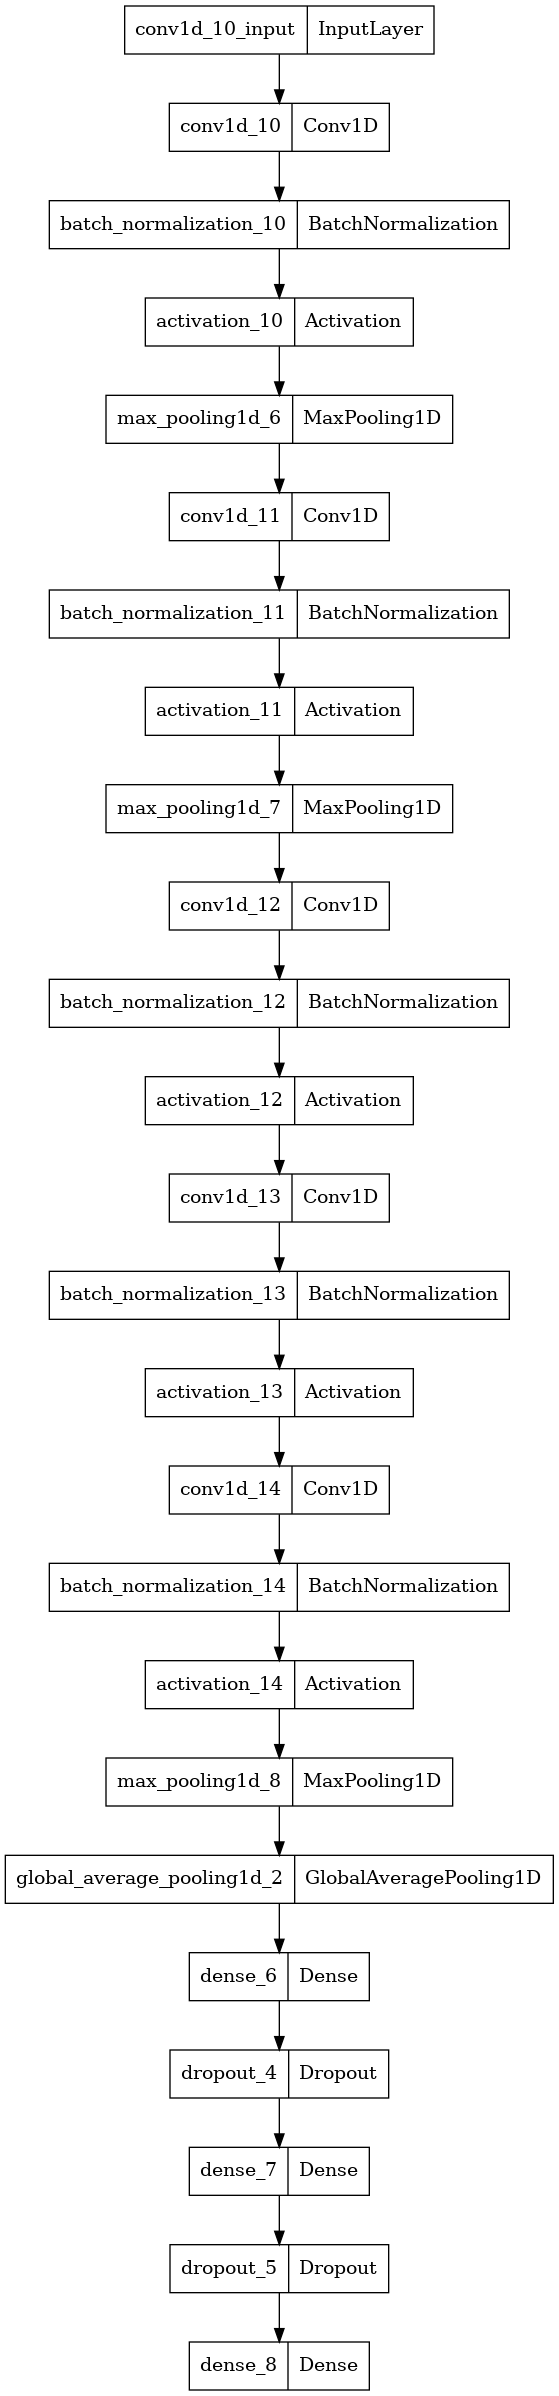

In [62]:
plot_model(alexNet_model)

In [59]:
batchsize = 10
epochs = 3
alexNet_model.fit(x=shuffle_batch(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=epochs, validation_data=generate_validation_data(ecg_filenames, y, folds[0][1]))
print('DONE')
model.save('model1')



Epoch 1/3
  88672/Unknown - 16985s 192ms/step - loss: 0.0901 - accuracy: 0.5657

KeyboardInterrupt: 

In [60]:
alexNet_model.save('model1')
# new_model = tf.keras.models.load_model('model1')

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets
